# GAN Inference Notebook
This notebook allows you to load a trained generator model and perform inference on 10 manually specified masked images.

# Imports and Setup
Import the required libraries and set up the computation device.

In [28]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import os
import dill

# Set up the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the Generator Model
Specify the path to the saved generator model and load its weights. The full model was saved during training.

In [29]:
# Hardcoded subdirectory name
sub_dir_name = "Small_training_testing"
model_dir = "saved_models"
sub_dir_path = os.path.join(model_dir, sub_dir_name)

# Ensure subdirectory exists
if not os.path.exists(sub_dir_path):
    raise FileNotFoundError(f"The directory '{sub_dir_path}' does not exist.")

# Path to the saved generator model
generator_path = os.path.join(sub_dir_path, "generator_full.pth")

# Load the full generator model using dill
try:
    generator = torch.load(generator_path, map_location=device, pickle_module=dill)
    generator.eval()  # Set the generator to evaluation mode
    print(f"Full generator model loaded successfully from: {generator_path}")
except Exception as e:
    print(f"Error loading the generator model: {e}")
    raise

Full generator model loaded successfully from: saved_models\Small_training_testing\generator_full.pth


# Define Image Preprocessing and Postprocessing
Set up functions to preprocess input images and denormalize outputs for visualization.

In [30]:
# Preprocessing: Resize, normalize, and convert to tensor
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match training size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

# Denormalize images for visualization
def denormalize(tensor):
    return tensor * 0.5 + 0.5

# Provide Paths to Masked Images
Manually define paths to 10 masked images to generate reconstructions.

In [31]:
# Path to the reference images directory
reference_images_dir = "Reference_Images"

# List all files in the reference images directory
masked_image_paths = [
    os.path.join(reference_images_dir, filename)
    for filename in os.listdir(reference_images_dir)
    if filename.endswith((".jpg", ".jpeg", ".png"))  # Ensure only image files are included
]

# Check if the directory contains any images
if not masked_image_paths:
    raise ValueError(f"No images found in the directory: {reference_images_dir}")


# Load and preprocess the masked images
masked_images = []
for file_path in masked_image_paths:
    image = Image.open(file_path).convert("RGB")
    masked_images.append(transform(image))

# Stack images into a batch
masked_images = torch.stack(masked_images).to(device)

# Generate and Display Reconstructed Images
Generate reconstructed images from the masked inputs and display them alongside the masked images.

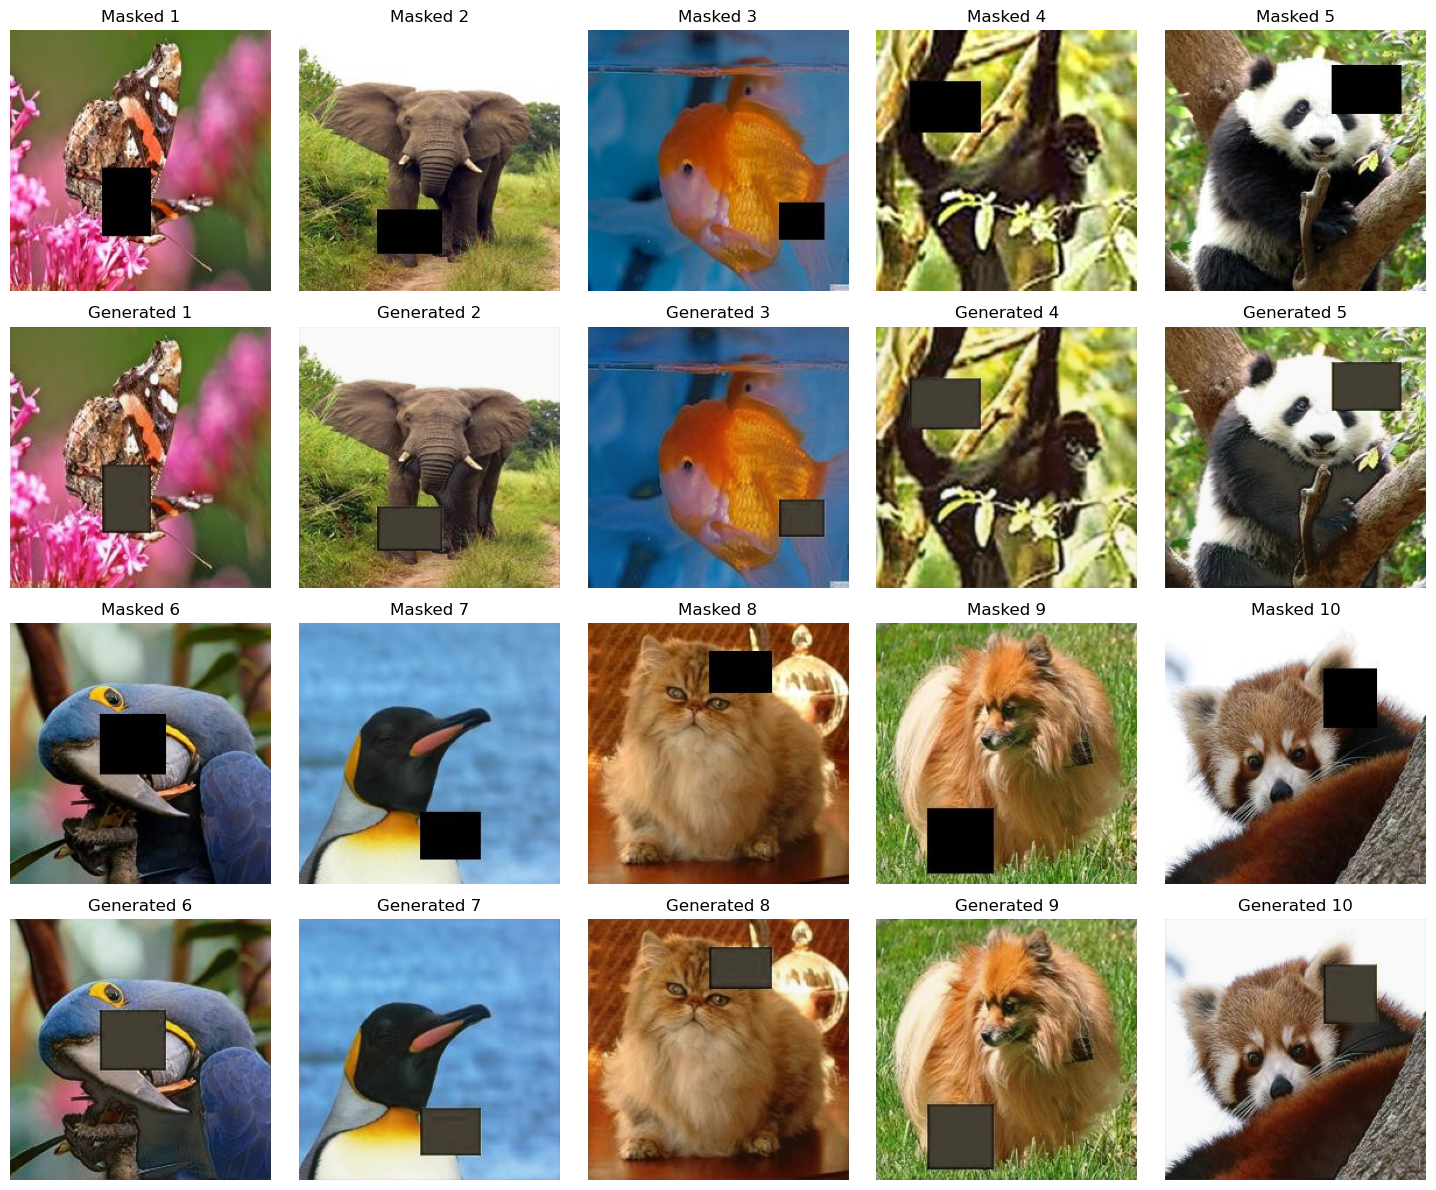

In [32]:
# Generate reconstructed images
with torch.no_grad():
    generated_images = generator(masked_images)

# Denormalize images
masked_images = denormalize(masked_images)
generated_images = denormalize(generated_images)

# Display masked and generated images in 4 rows (5 images per row)
fig, axs = plt.subplots(4, 5, figsize=(15, 12))  # 4 rows, 5 columns

for i in range(10):
    # First 5 images (Masked and Generated)
    if i < 5:
        # Masked images (Row 1)
        axs[0, i].imshow(masked_images[i].permute(1, 2, 0).cpu().numpy())
        axs[0, i].axis("off")
        axs[0, i].set_title(f"Masked {i+1}")

        # Generated images (Row 2)
        axs[1, i].imshow(generated_images[i].permute(1, 2, 0).cpu().numpy())
        axs[1, i].axis("off")
        axs[1, i].set_title(f"Generated {i+1}")
    else:
        # Masked images (Row 3)
        axs[2, i - 5].imshow(masked_images[i].permute(1, 2, 0).cpu().numpy())
        axs[2, i - 5].axis("off")
        axs[2, i - 5].set_title(f"Masked {i+1}")

        # Generated images (Row 4)
        axs[3, i - 5].imshow(generated_images[i].permute(1, 2, 0).cpu().numpy())
        axs[3, i - 5].axis("off")
        axs[3, i - 5].set_title(f"Generated {i+1}")

# Add space between rows 2 and 3
fig.subplots_adjust(hspace=0.6)

plt.tight_layout()
plt.show()